## Naive Repeated Median Filter

In [4]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

%load_ext Cython
%load_ext line_profiler

In [6]:
import numpy as np
import sys
# change the following path to your local repository of energyanalytics
mod_path = '/Users/Simo//Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/RepeatedMedianFilter'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
    
#from bayesian_cp_detect import bayesian_cp_3 as bcp
#from bayesian_cp_detect import cp_detect
#from bayesian_cp_detect.example import Dissagregation_functions as example
import RMFilter
# make sure that the code is loaded to the lastest version
reload(RMFilter)

RMF = RMFilter.RepeatedMedianFilter()
import SteadyStateDetection 
SSD = SteadyStateDetection.SteadyStateDetector()


def RepeatedMedianHybridFilters(data,k = 5):
    to_return = []
    N = len(data)
    for t in range(k,N-k):
        median_slope_list= []
        for i in range(-k,k): 
            # compute the median of slope for each t+i
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        mu = np.median([data[t+j]+k*slope for j in range(-k,k)])
        to_return.append(mu)    
    return to_return


def RepeatedMedianHybridFilters2(data,k = 5):
    to_return = []
    N = len(data)
    for t in range(k,N-k):
        median_slope_list= []
        for i in range(-k,k): 
            # compute the median of slope for each t+i
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        mu = np.median([data[t+j]+k*slope for j in range(-k,k)])
        mu_F = np.median(data[t-k:t])
        mu_B = np.median(data[t:t+k])
        to_return.append(np.median([mu_F,mu,mu_B]))    
    return to_return


In [83]:
def rmfsubroutine2(data,k,t):
    median_slope_list= []
    for i in range(-k,k): 
        # compute the median of slope for each t+i
        slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
        median_slope_list.append(slope)
    slope = np.median(median_slope_list)
    mu = np.median([data[t+j]+k*slope for j in range(-k,k)])
    mu_F = np.median(data[t-k:t])
    mu_B = np.median(data[t:t+k])
    return np.median([mu_F,mu,mu_B])

In [90]:
from joblib import Parallel, delayed
data = input_data
to_return = []
N = len(data)
%timeit Parallel(n_jobs=4, backend="threading")(delayed(rmfsubroutine2)(data,k,t) for t in range(k,N-k))

KeyboardInterrupt: 

In [91]:
%timeit RMF._repeated_median_hybrid_filter(input_data,k)

KeyError: 0

## Compare with Numba

In [61]:
from numba import autojit, prange

@autojit
def RepeatedMedianHybridFilters2numba(data,k = 5):
    to_return = []
    N = len(data)
    for t in prange(k,N-k):
        median_slope_list= []
        for i in range(-k,k): 
            # compute the median of slope for each t+i
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        mu = np.median([data[t+j]+k*slope for j in range(-k,k)])
        mu_F = np.median(data[t-k:t])
        mu_B = np.median(data[t:t+k])
        to_return.append(np.median([mu_F,mu,mu_B]))    
    return to_return

ImportError: cannot import name config

## Compare with cython acceleration

In [25]:
%load_ext Cython

%cython
def RepeatedMedianHybridFiltersCython(data,k = 5):
    to_return = []
    N = len(data)
    for t in range(k,N-k):
        median_slope_list= []
        for i in range(-k,k): 
            # compute the median of slope for each t+i
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        mu = np.median([data[t+j]+k*slope for j in range(-k,k)])
        to_return.append(mu)    
    return to_return

SyntaxError: invalid syntax (<ipython-input-25-9669fc59c587>, line 7)

In [27]:
%%cython

import numpy as np
cimport numpy as np
import cython

cdef RepeatedMedianHybridFiltersCython(data,k = 5):
    to_return = []
    N = len(data)
    for t in range(k,N-k):
        median_slope_list= []
        for i in range(-k,k): 
            # compute the median of slope for each t+i
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        mu = np.median([data[t+j]+k*slope for j in range(-k,k)])
        to_return.append(mu)    
    return to_return

In [42]:
%lprun -f RMF._repeated_median_hybrid_filter RMF._repeated_median_hybrid_filter(input_data,k)

In [44]:
%lprun -f RepeatedMedianHybridFiltersCython RepeatedMedianHybridFiltersCython(input_data,k)

## Compare with median filter

In [75]:
%lprun -f RMF._repeated_median_hybrid_filter RMF._repeated_median_hybrid_filter(x2,k)
#%lprun -f RepeatedMedianHybridFilters RepeatedMedianHybridFilters(x2,k)
#%timeit  RMF._repeated_median_hybrid_filter(x2,k)

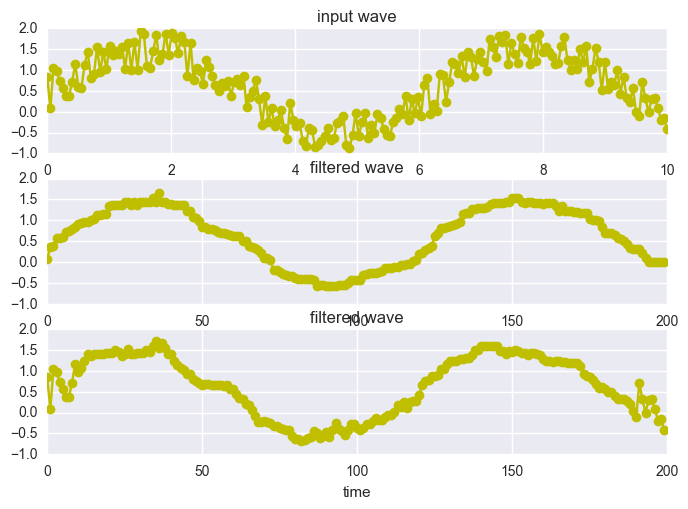

In [11]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
k  = 10
t = np.linspace(0,10,200) # create a time signal
x1 = np.sin(t) # create a simple sine wave
x2 = x1 + np.random.rand(200) # add noise to the signal
y1 = sp.signal.medfilt(x2,21) # add noise to the signal
y2 = list(x2[:k])+RMF._repeated_median_hybrid_filter(x2,k)+list(x2[-k:])
# plot the results
plt.subplot(3,1,1)
plt.plot(t,x2,'yo-')
plt.title('input wave')
plt.xlabel('time')
plt.subplot(3,1,2)
plt.plot(range(200),y1,'yo-')
plt.title('filtered wave')
plt.xlabel('time')
plt.subplot(3,1,3)
plt.plot(range(200),y2,'yo-')
plt.title('filtered wave')
plt.xlabel('time')
plt.figure(figsize=(80, 40), dpi= 800, facecolor='w', edgecolor='k')
#plt.set_figheight(15)
#plt.set_figwidth(15)
plt.show()

## Run on real data


In [1]:
import pandas as pd
#total_data = pd.DataFrame.from_csv('/Users/Simo/Desktop/equota/大商业空调负荷.csv')
total_data = pd.DataFrame.from_csv('/Users/Simo/Desktop/equota/new_load.csv')
total_data['2017-05-16':'2017-08-16']

,2.06266666667
2017-05-17 00:00:00+08:00,
2017-05-16 16:05:00,2.062667
2017-05-16 16:10:00,2.062667
2017-05-16 16:15:00,2.062667
2017-05-16 16:20:00,2.062667
2017-05-16 16:25:00,2.972667
2017-05-16 16:30:00,2.972667
2017-05-16 16:35:00,2.972667
2017-05-16 16:40:00,2.972667
2017-05-16 16:45:00,2.972667


In [2]:
%matplotlib inline
test_data = total_data.fillna(0)[400:5839]
plt.plot(test_data)

NameError: name 'plt' is not defined

In [92]:
#input_data = list(test_data['mean_zgcs17'].values)
input_data = test_data.values
input_data = [i[0] for i in input_data]

In [4]:
test_data.values

array([[  2.74166667e+00],
       [  2.74166667e+00],
       [  2.74166667e+00],
       ..., 
       [  5.80988893e+03],
       [  5.78511687e+03],
       [  5.86696133e+03]])

In [40]:
double_filter = True
k = 5
#filtered_data = list(input_data[:k])+RepeatedMedianHybridFilters(input_data,k)+list(input_data[-k:])
if double_filter:
    filtered_data = sp.signal.medfilt(input_data,5)
    k = 15
filtered_data = list(filtered_data[:k])+RMF.repeated_median_hybrid_filter(filtered_data,k)+list(filtered_data[-k:])

AttributeError: RepeatedMedianFilter instance has no attribute 'RepeatedMedianHybridFilter'

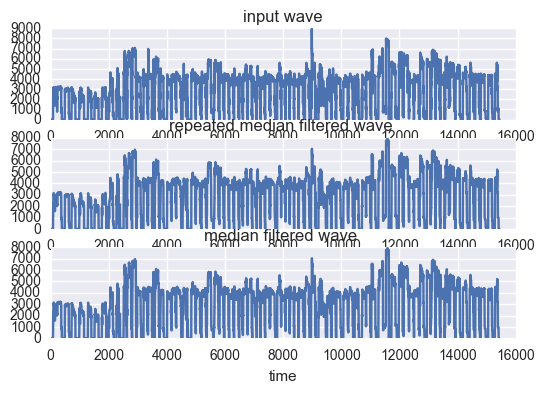

In [41]:
# plot the results
plt.subplot(3,1,1)
plt.plot(input_data)
plt.title('input wave')
plt.xlabel('time')
plt.subplot(3,1,2)
plt.plot(filtered_data)
plt.title('repeated median filtered wave ')
plt.xlabel('time')
plt.subplot(3,1,3)
plt.plot(sp.signal.medfilt(input_data,5))
plt.title('median filtered wave ')
plt.xlabel('time')
#plt.set_figheight(15)
#plt.set_figwidth(15)
plt.show()

## Find Changepoint

In [44]:
import sys
# change the following path to your local repository of energyanalytics
mod_path = '/Users/Simo//Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
    
from bayesian_cp_detect import bayesian_cp_3 as bcp
from bayesian_cp_detect import cp_detect
from bayesian_cp_detect.example import Dissagregation_functions as example

# make sure that the code is loaded to the lastest version
reload(bcp)


<module 'bayesian_cp_detect.bayesian_cp_3' from '/Users/Simo//Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation/bayesian_cp_detect/bayesian_cp_3.pyc'>

### Raw Data

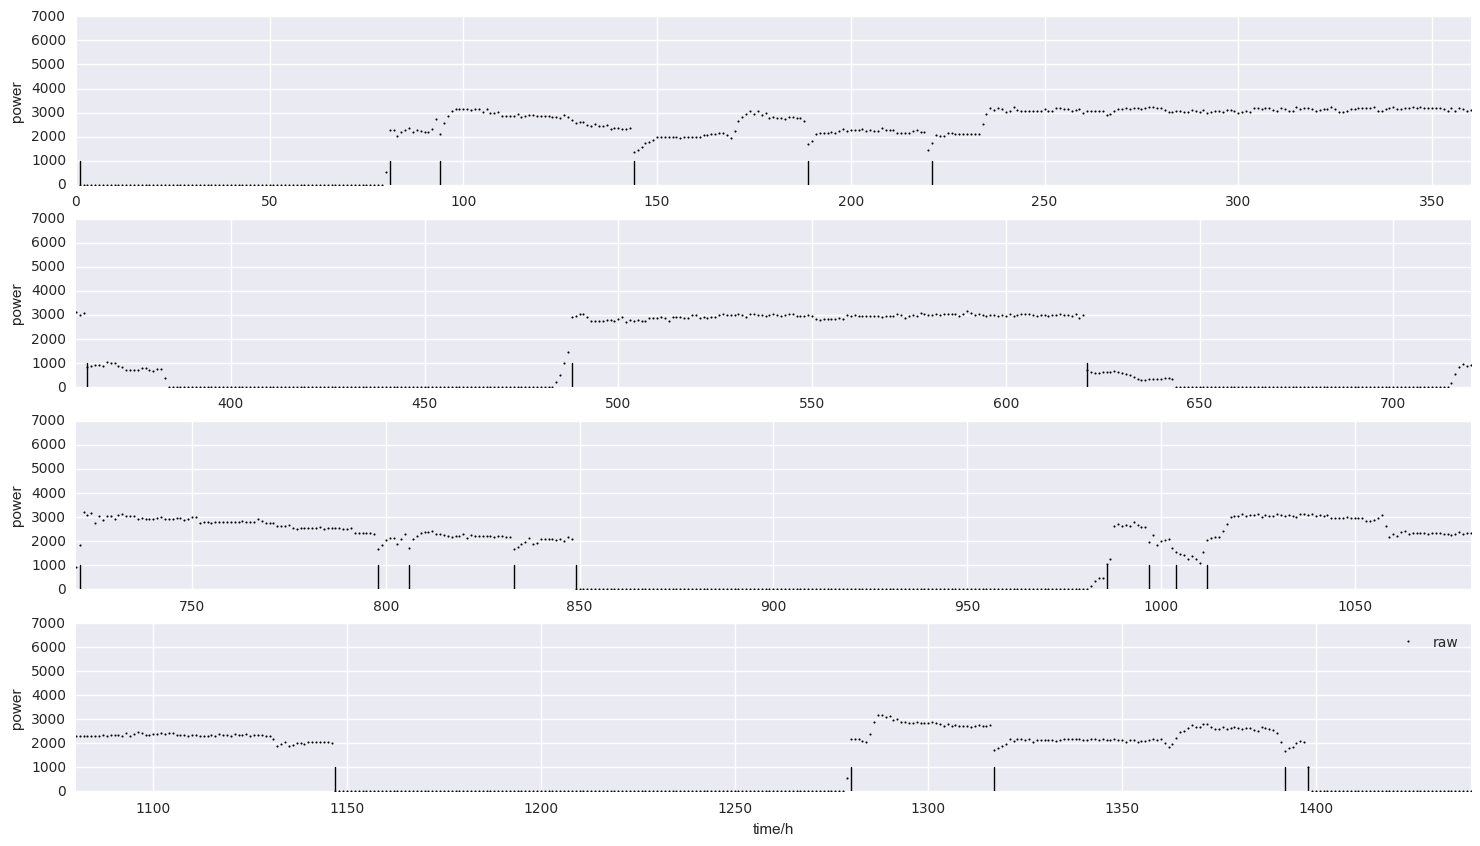

In [48]:
#y = test_data['mean_zgcs17'].values
y = input_data
t=np.array([i+1 for i in range(len(y))])

# Compute the changepoints
t_2, y_2 = bcp.rel_change_filter_0819_3(t,y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
changepoint.append(len(t_2)-1)
example.plot_24h_data(t_2,y_2,changepoint)

## Method 2

In [73]:
# Test code 

slope = SlopeMedianFilter(y)
threshold = 200
non_stationary = []
N = len(y)
for i in changepoint:
    for j in (-threshold,threshold):
        if i+j>0 and i+j<N  and slope[i+j]==0:
            non_stationary.append(i+j)
print non_stationary
non_stationary = list(set(non_stationary))
print len(non_stationary)
print len(changepoint)

[280, 162, 997, 1005, 632, 796, 1771, 1774, 1777, 1565, 1573, 2062, 2585]
13
47


In [45]:
# Idea: use the changepoints from raw data and exclude the points with large median slopes around the changepoints

def SlopeMedianFilter(data,k = 5,slope_threshold = 20):
    to_return = []
    N = len(data)
    # the first k elements
    for t in range(k):
        median_slope_list = []
        for i in range(k):
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        to_return.append(slope)
    # the elements in the middle
    for t in range(k,N-k):
        median_slope_list= []
        for i in range(-k,k): 
            # compute the median of slope for each t+i
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,k) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        to_return.append(slope)
    # the last k elements
    for t in range(N-k,N):
        median_slope_list = []
        for i in range(-k,0):
            slope = np.median( [(data[t+i]-data[t+j])/(i-j) for j in range(-k,0) if j!=i] )      
            median_slope_list.append(slope)
        slope = np.median(median_slope_list)
        to_return.append(slope)
    # compute the mean and standard deviation of median list
    mean = np.mean(to_return)
    std = np.std(to_return)
    # 1 stands for steady state points 
    toreturn = [1 if abs(i-mean)<std and abs(i)<slope_threshold else 0 for i in to_return ]
    return toreturn



In [57]:
reload(SteadyStateDetection)
SSD = SteadyStateDetection.SteadyStateDetector()
base = SSD.steady_state_using_median_slope(input_data)
%matplotlib inline
plt.plot(base)
plt.plot(input_data)

AttributeError: SteadyStateDetector instance has no attribute 'SteadyStateUsingMedianSlope'

In [58]:
%lprun -f SSD.steady_state_using_median_slope SSD.steady_state_using_median_slope(input_data)

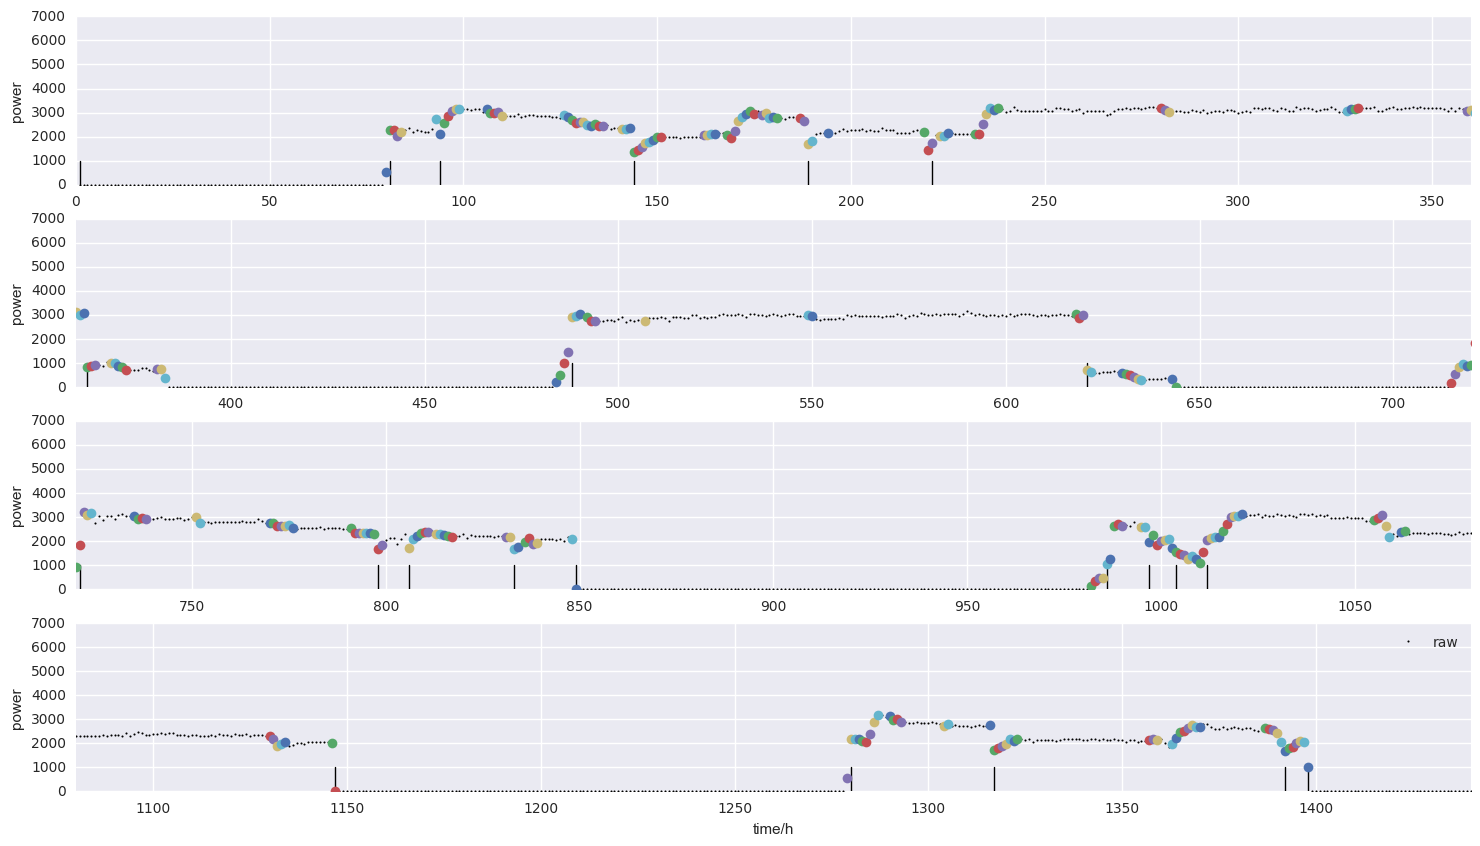

In [65]:
def plot_stationary_data(t, raw_data,cp_list,slopefiltered,k=360,threshold = 5):
    fig, axes = plt.subplots(nrows=4, figsize=[18, 10])
    
    for i, ax in enumerate(axes):
        #ax.plot(t, data, 'r-', markersize=3, linewidth=1, label='smooth')
        ax.plot(t, raw_data, 'k.', markersize=3, label='raw')     
        for cp in cp_list:
            ax.plot([t[cp], t[cp]], [0, 1000], 'k-', linewidth=1)
        for temp in range(len(slopefiltered)):
            if slope[temp]==0:
                ax.plot(t[temp],raw_data[temp],marker = 'o',)
        ax.set_ylabel('power')
        ax.set_xlim([0+i*k,k+i*k])
    ax.set_xlabel('time/h')
    plt.legend()

slope = SlopeMedianFilter(y)
plot_stationary_data(t_2,y_2,changepoint,slope)

In [39]:
def ChangepointToStationaryState(changepoint,data):
    toreturn = []
    for i in range(len(changepoint)-1):
        temp = np.mean(data[changepoint[i]:changepoint[i+1]])
        toreturn = toreturn+[temp]*(changepoint[i+1]-changepoint[i])
    return toreturn

'\nbase = ChangepointToStationaryState(changepoint,y)\nplt.plot(base)\nplt.plot(y)\n'

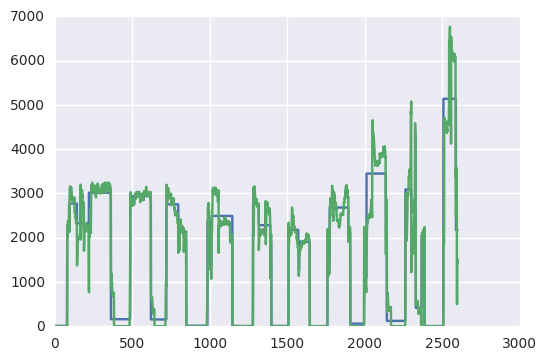

In [110]:
%matplotlib inline
reload(SteadyStateDetection)
SSD = SteadyStateDetection.SteadyStateDetector()
base = SSD.SteadyStateWithoutFilter(input_data)
plt.plot(base)
plt.plot(input_data)
'''
base = ChangepointToStationaryState(changepoint,y)
plt.plot(base)
plt.plot(y)
'''

### Repeated Median Filter

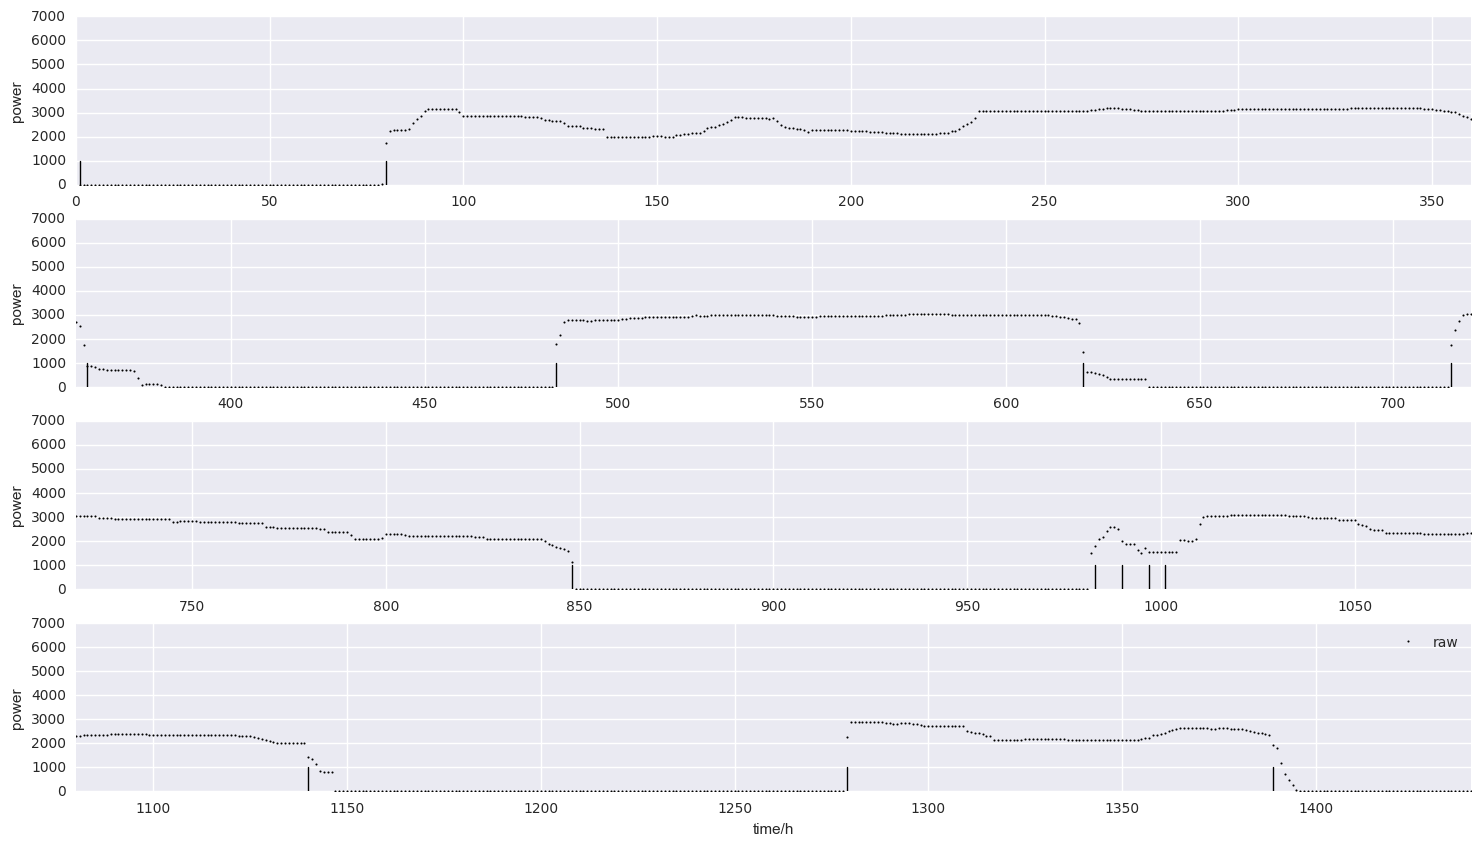

In [12]:
'''
using small time window (k=5) and median filter first and then use large time window to cancel 
large spikes, after that pass to the change point algorithm

'''
y = filtered_data
t=np.array([i+1 for i in range(len(y))])

# Compute the changepoints
t_2, y_2 = bcp.rel_change_filter_0819_3(t,y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
changepoint.append(len(t_2)-1)
example.plot_24h_data(t_2,y_2,changepoint)

<IPython.core.display.Javascript object>


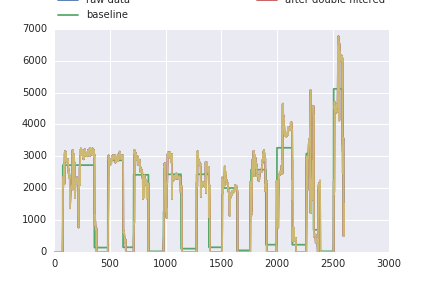

'\n%matplotlib notebook\n\nbase = ChangepointToStationaryState(changepoint,y)\n#plt.plot(test_data[\'mean_zgcs17\'].values,label="raw data")\nplt.plot(input_data,label="raw data")\nplt.plot(base,label="baseline")\nplt.plot(y,label="after double filtered")\nplt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,\n           ncol=2, mode="expand", borderaxespad=0.)\n'

In [120]:
reload(SteadyStateDetection)
SSD = SteadyStateDetection.SteadyStateDetector()
base = SSD.SteadyStatewithDoubleFilter(input_data)
%matplotlib notebook

#base = ChangepointToStationaryState(changepoint,y)
#plt.plot(test_data['mean_zgcs17'].values,label="raw data")
plt.plot(input_data,label="raw data")
plt.plot(base,label="baseline")
plt.plot(input_data,label="after double filtered")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

'''
%matplotlib notebook

base = ChangepointToStationaryState(changepoint,y)
#plt.plot(test_data['mean_zgcs17'].values,label="raw data")
plt.plot(input_data,label="raw data")
plt.plot(base,label="baseline")
plt.plot(y,label="after double filtered")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
'''

### Median Filter

<IPython.core.display.Javascript object>


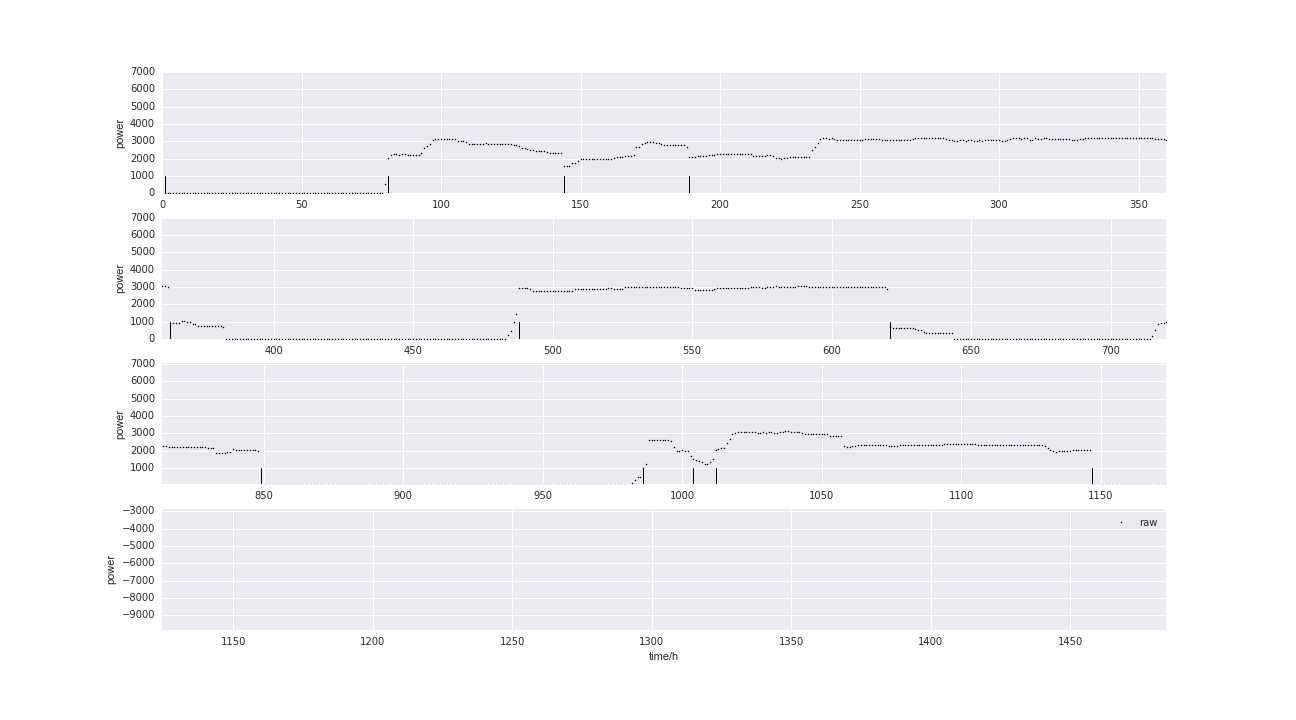

In [64]:
y = sp.signal.medfilt(input_data,5)
t=np.array([i+1 for i in range(len(y))])

# Compute the changepoints
t_2, y_2 = bcp.rel_change_filter_0819_3(t,y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
changepoint.append(len(t_2)-1)
example.plot_24h_data(t_2,y_2,changepoint)

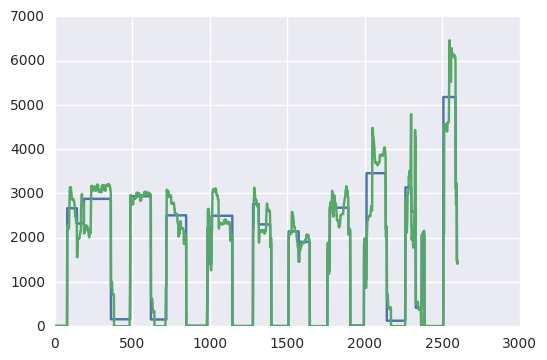

In [68]:
%matplotlib inline
base = ChangepointToStationaryState(changepoint,y)
plt.plot(base)
plt.plot(y)